# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

Agent can move forward and backward with probability 0.8

Agent can move sideways with probability 0.9

# Class definition

In [ ]:
class Grid:
    def __init__(self):
        self.cols = 25
        self.rows = 15
        self.GAMMA = 0.95
        self.EPSILON = 0.1
        self.ALPHA = 0.5
        self.no_of_actions = 4  # Up, Down, Left, Right or N, S, W, E
        self.start_state = [0, 0]   # Start state
        self.goal_states = [[14, 24]]    # Goal state
        self.obstacles = [[0, 1], [2, 14], [2, 3], [4,14], [17, 8], [22, 2], [3, 3], [23, 1], [14,4], [24,0], [23,2], [6,7]]   # list of obstacles state
        self.max_runs = 100     # Maximum episodes
        self.beliefs = {}

    # Function to return next state and reward
    def next_state(self, state, action):
        x, y = state
        reward = 0
        if action == 0:  # UP or N action
            x = max( x - 1, 0 ) # Ensures agent remains in grid
        elif action == 1:  # DOWN or S action
            x = min( x + 1, self.rows - 1 ) # Ensures agent remains in grid
        elif action == 2:  # LEFT or W action
            y = max( y - 1, 0 ) # Ensures agent remains in grid
        elif action == 3:  # RIGHT or E action
            y = min( y + 1, self.cols - 1 ) # Ensures agent remains in grid

        # -100 reward if the next state is out of grid
        if x == state[0] and y == state[1]:
            reward = -100
        # -100 reward if state is an obstacle
        if [x, y] in self.obstacles:
            x, y = state
            reward = -100
        # +100 reward if the next state is goal
        if [x, y] in self.goal_states:
            reward = 100
        return [x, y], reward

    # Function for epsilon greedy action selection
    def take_action(self, state, q_value_function):
        if random.random() < self.EPSILON: # Exploratory action
            return np.random.randint( 0, 3 )
        else: # Greedy action
            max_values = np.max( q_value_function[state[0]][state[1]][:] )
            list_of_max_values_indexes = []
            for i in range( len( q_value_function[state[0]][state[1]][:] ) ):
                if q_value_function[state[0]][state[1]][i] == max_values:
                    list_of_max_values_indexes.append( i )
            return np.random.choice( list_of_max_values_indexes )

    # Function to decide whether we should take the action taken or not based on transition probabilities
    def whether_to_take_action(self, action, orientation):
        p1 = random.random()  # for forward and backward
        p2 = random.random()  # for left and right

        if orientation in [0, 1]:  # Orientation of agent is facing UP or DOWN
            if action in [0, 1]:  # Action is UP or DOWN i.e. going forward or backward
                if p1 <= 0.8:
                    return 1
                else:
                    return 0
            else:  # Action is LEFT or RIGHT i.e. taking turn
                if p2 <= 0.9:
                    return 1
                else:
                    return 0
        else:  # Orientation of agent is facing LEFT or RIGHT
            if action in [0, 1]:  # Action is UP or DOWN i.e. taking turn
                if p1 <= 0.9:
                    return 1
                else:
                    return 0
            else:  # Action is LEFT or RIGHT i.e. going forward or backward
                if p2 <= 0.8:
                    return 1
                else:
                    return 0

    # Function to approximate score of action
    def function_approximation(self, action, q_values):
        sum_q_ba = 0
        key = list( self.beliefs.keys() )
        values = list( self.beliefs.values() )
        for r in range( len( key ) ):
            sum_q_ba += values[r] * q_values[key[r][0]][key[r][1]][action]
        return sum_q_ba

    # Function to return observation probabilities
    def observation_probability(self, state, action):
        [x, y], rwd = self.next_state( state, action )
        if rwd == -100 or [x, y] == state:
            return 0 # Partial observability
        else:
            return 1

    # Function to return transition probabilities
    def transition_probability(self, pre_state, state, action, pre_ori):
        if action in [0, 1] and pre_ori in [0, 1]:      # if action is forward or backward
            if pre_state[0:2] == state:     # if agent is statying at same state even after taking action
                return 0.2
            else:
                return 0.8
        else:       # if action is sideways
            if pre_state[0:2] == state:     # if agent is statying at same state even after taking action
                return 0.1
            else:
                return 0.9

    # Function to check validity of states
    def if_valid_state(self, state):
        if state[0:2] in self.goal_states or state[0:2] in self.obstacles \
                or state[0] < 0 or state[0] >= self.rows or state[1] < 0 or state[1] >= self.cols:
            return 0
        else:
            return 1

    # Utility function for computing the numerator for updating the beliefs
    def sigma_transition(self, next_state, action, orientation):
        sigma = 0
        list_previous_states = []  # this list will store the possible actions from where agent can reach the next state
        probable_list = []
        list_previous_states.append( [next_state[0], next_state[1] - 1, 3] )  # right
        list_previous_states.append( [next_state[0] + 1, next_state[1], 0] )  # up
        list_previous_states.append( [next_state[0], next_state[1] + 1, 2] )  # left
        list_previous_states.append( [next_state[0] - 1, next_state[1], 1] )  # down

        for i in range( 4 ):
            list_previous_states.append( [next_state[0], next_state[1], i] )
        for st in list_previous_states:
            if st[2] == action and self.if_valid_state( st ):
                tp = self.transition_probability( st, next_state, action, orientation )
                probable_list.append( st )
                if self.beliefs.get( (st[0], st[1]) ) is not None:
                    sigma += tp * self.beliefs.get( (st[0], st[1]) )
        return sigma, probable_list

    # Function to update belief probabilities of next state
    def update_beliefs(self, state, next_state, action, orientation):
        p = self.observation_probability( state, action )
        sigma, prob_list_states = self.sigma_transition( next_state, action, orientation )
        deno = 0
        for each_state in prob_list_states:
            deno += sigma * self.observation_probability( [each_state[0], each_state[1]], each_state[2] )
        belief = {}
        if p != 0 and sigma != 0:
            belief[(next_state[0], next_state[1])] = p * sigma / deno # Normalising
            self.beliefs = belief

In [ ]:
grid = Grid()
q_value_function = np.zeros( (grid.rows, grid.cols, grid.no_of_actions) )
orientation = 0
run = 0
counting_steps = []

In [ ]:
while (run < grid.max_runs):
        print('*****************************************')
        run += 1
        grid.beliefs[(0, 0)] = 1  # Belief at initial location is 0 initially
        state = grid.start_state
        step = 0
        while state not in grid.goal_states:
            step += 1
            action = grid.take_action( [state[0], state[1], orientation], q_value_function )  # Action to take
            # If the action can be taken
            if grid.whether_to_take_action( action, orientation ) == 1:
                next_state, reward = grid.next_state( state, action )  # Take action and obtain next state and reward
                q_ba = grid.function_approximation( action, q_value_function )
                b_s = grid.beliefs.get( (state[0], state[1]) )
                # Update belief
                grid.update_beliefs( state, next_state, action, orientation )
                list_qc = []  # Storing purpose
                for a in range( 4 ):
                    list_qc.append( grid.function_approximation( a, q_value_function ) )
                # Q value update
                q_value_function[state[0], state[1], action] += (
                            grid.ALPHA * b_s * (reward + grid.GAMMA * max( list_qc ) - q_ba))
                # Changing the orientation of the agent
                orientation = action
                state = next_state
            else:
                continue
            if reward == 100:
                print( 'Episode: ', run, '    No. of steps taken: ', step )
                counting_steps.append( step )
                break

*****************************************
Episode:  1     No. of steps taken:  15224
*****************************************
Episode:  2     No. of steps taken:  4294
*****************************************
Episode:  3     No. of steps taken:  3015
*****************************************
Episode:  4     No. of steps taken:  1190
*****************************************
Episode:  5     No. of steps taken:  3721
*****************************************
Episode:  6     No. of steps taken:  2293
*****************************************
Episode:  7     No. of steps taken:  12105
*****************************************
Episode:  8     No. of steps taken:  14182
*****************************************
Episode:  9     No. of steps taken:  3025
*****************************************
Episode:  10     No. of steps taken:  2617
*****************************************
Episode:  11     No. of steps taken:  12716
*****************************************
Episode:  12     No. of step

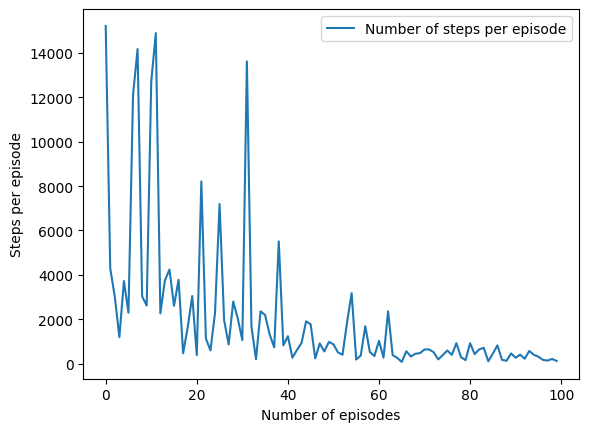

In [ ]:
# Plotting the graph
plt.plot( range( 0, grid.max_runs ), counting_steps, label='Number of steps per episode' )
plt.xlabel( 'Number of episodes' )
plt.ylabel( 'Steps per episode' )
plt.legend()
plt.show()